# True Fixed Polynomial Regression with SGD

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic polynomial data with fixed coefficients. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error. Here, we aim to assess how SGD performs when the model matches the true data-generating process as well as overfitting and underfitting with different degrees.


In [1]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from src.sgd.sgd import SGD
from src.models.regression_model import RegressionModel
from src.data.generate_synthetic_data import generate_training_data_fixed, transform_to_polynomial
from sklearn.model_selection import train_test_split

### Summary of Train/Test Error Over 20 Runs

We generate new synthetic data each time and report mean ± std of final losses.

In [2]:
np.random.seed(0)
X_raw, _, _ = generate_training_data_fixed(m=5000, n=2, noise=0.001)
true_degree = 3
X_true_poly = transform_to_polynomial(X_raw, degree=true_degree, normalize=True)

true_A = 0.1 * np.arange(1, X_true_poly.shape[1] + 1)
true_b = 1.0
noise = 0.001
y = X_true_poly @ true_A + true_b + np.random.normal(0, noise, size=X_true_poly.shape[0])

train_losses = {}
test_losses = {}
results = {}

degrees = [1, 2, 3, 4, 5]

for degree in degrees:
    print(degree)
    X_poly = transform_to_polynomial(X_raw, degree=degree, normalize=True)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

    train_losses[degree] = {}
    test_losses[degree] = {}
    results[degree] = {}

    for method in ["fixed", "halving", "diminishing"]:
        print(method)
        model = RegressionModel(X_train, y_train)
        sgd = SGD(model=model, num_epochs=5, batch_size=1, noise=noise, stepsize_type=method)
        w, obj, *_ = sgd.optimize()

        train_loss = obj[-1]
        test_pred = X_test @ w[1:] + w[0]
        test_loss = np.mean((test_pred - y_test) ** 2)

        train_losses[degree][method] = train_loss
        test_losses[degree][method] = test_loss
        results[degree][method] = {
            "w": w,
            "obj": obj,
            "F_star": sgd.F_star,
            "params": sgd.params,
            "scheduler": sgd.strategy
        }

# === Print results summary ===
for degree in degrees:
    print(f"\n==== Results for Degree {degree} ====")
    for method in ["fixed", "halving", "diminishing"]:
        print(f"{method.capitalize()} Step Size:")
        print(f"  Final Training Loss: {train_losses[degree][method]:.4f}")
        print(f"  Final Testing Loss:  {test_losses[degree][method]:.4f}")


1
fixed
halving
diminishing
2
fixed
halving
diminishing
3
fixed
halving
diminishing
4
fixed
halving
diminishing
5
fixed
halving
diminishing

==== Results for Degree 1 ====
Fixed Step Size:
  Final Training Loss: 0.8047
  Final Testing Loss:  2.3205
Halving Step Size:
  Final Training Loss: 0.8447
  Final Testing Loss:  2.2095
Diminishing Step Size:
  Final Training Loss: 0.7341
  Final Testing Loss:  2.1437

==== Results for Degree 2 ====
Fixed Step Size:
  Final Training Loss: 0.7742
  Final Testing Loss:  0.7659
Halving Step Size:
  Final Training Loss: 0.9047
  Final Testing Loss:  0.8033
Diminishing Step Size:
  Final Training Loss: 0.7464
  Final Testing Loss:  0.8020

==== Results for Degree 3 ====
Fixed Step Size:
  Final Training Loss: 0.0000
  Final Testing Loss:  0.0000
Halving Step Size:
  Final Training Loss: 0.0000
  Final Testing Loss:  0.0000
Diminishing Step Size:
  Final Training Loss: 0.0007
  Final Testing Loss:  0.0021

==== Results for Degree 4 ====
Fixed Step Size

/var/folders/v8/k38qrhtj2sg_22kzbmh35pm40000gp/T/ipykernel_80109/1385485569.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


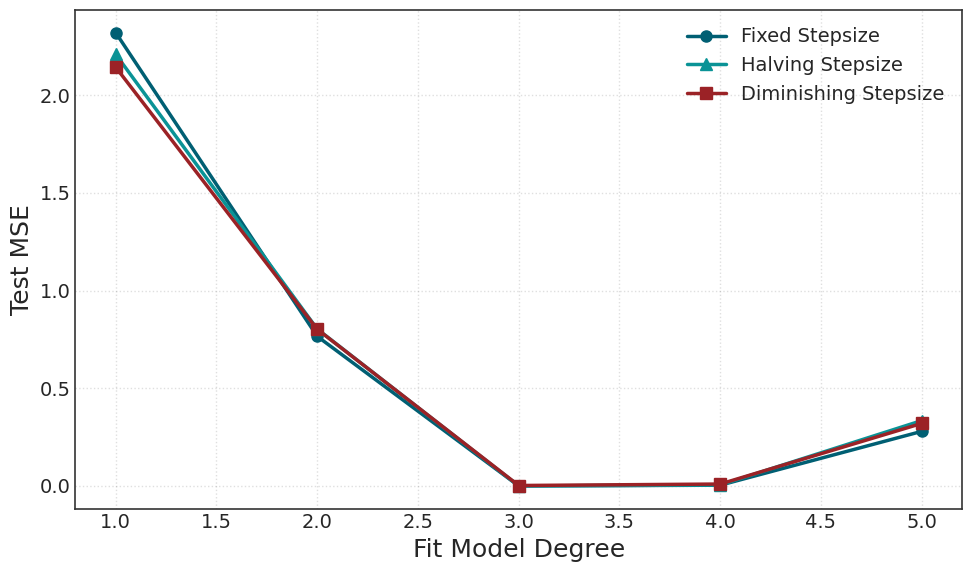

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Poster-style config
plt.style.use("seaborn-white")
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 16,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.frameon": False
})

# Color and marker scheme
colors = {
    "fixed": "#005F73",        # Deep teal
    "halving": "#0A9396",      # Turquoise
    "diminishing": "#9B2226"   # Brick red
}
markers = {
    "fixed": "o",
    "halving": "^",
    "diminishing": "s"
}

# Plot
plt.figure(figsize=(10, 6))
for method in ["fixed", "halving", "diminishing"]:
    test_means = [test_losses[d][method] for d in degrees]  
    plt.plot(degrees, test_means,
             label=f"{method.capitalize()} Stepsize",
             marker=markers[method],
             markersize=8,
             linewidth=2.5,
             color=colors[method])

# Axis labels and title
plt.xlabel("Fit Model Degree")
plt.ylabel("Test MSE")

# Grid, legend, layout
plt.grid(True, linestyle=":", linewidth=1, color="gray", alpha=0.25)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### Theoretical Constants

The following constants were computed from the problem to derive the various stepsizes.

In [4]:
print("==== Final Weights ====")
for degree in degrees:
    print(f"Degree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        print(f"  {method.capitalize()} Step Size: {results[degree][method]['w']}")
    print()

==== Final Weights ====
Degree 1:
  Fixed Step Size: [0.90960545 0.72040648 0.99916811]
  Halving Step Size: [0.89687516 1.27440746 1.2207995 ]
  Diminishing Step Size: [1.01026184 1.01032214 1.27947988]

Degree 2:
  Fixed Step Size: [1.00831545 0.81560158 1.18265524 0.37022856 0.33866186 0.40990313]
  Halving Step Size: [1.03479889 1.06046181 1.3774551  0.19828222 0.40505952 0.6124351 ]
  Diminishing Step Size: [0.97995532 1.0475577  1.35371409 0.32730508 0.32170957 0.36145493]

Degree 3:
  Fixed Step Size: [1.00002263 0.10009615 0.20012903 0.29994096 0.39992452 0.49993228
 0.59992685 0.70000902 0.79998133 0.8999619 ]
  Halving Step Size: [1.00000955 0.10030739 0.20039768 0.30001315 0.39998513 0.49991372
 0.59969985 0.69987408 0.79993912 0.89972273]
  Diminishing Step Size: [1.00007409 0.14218693 0.25115075 0.2998401  0.39871464 0.49688643
 0.56039187 0.67945326 0.79197108 0.86100887]

Degree 4:
  Fixed Step Size: [ 1.00027469  0.13003478  0.23931592  0.24075637  0.3829104   0.4376757

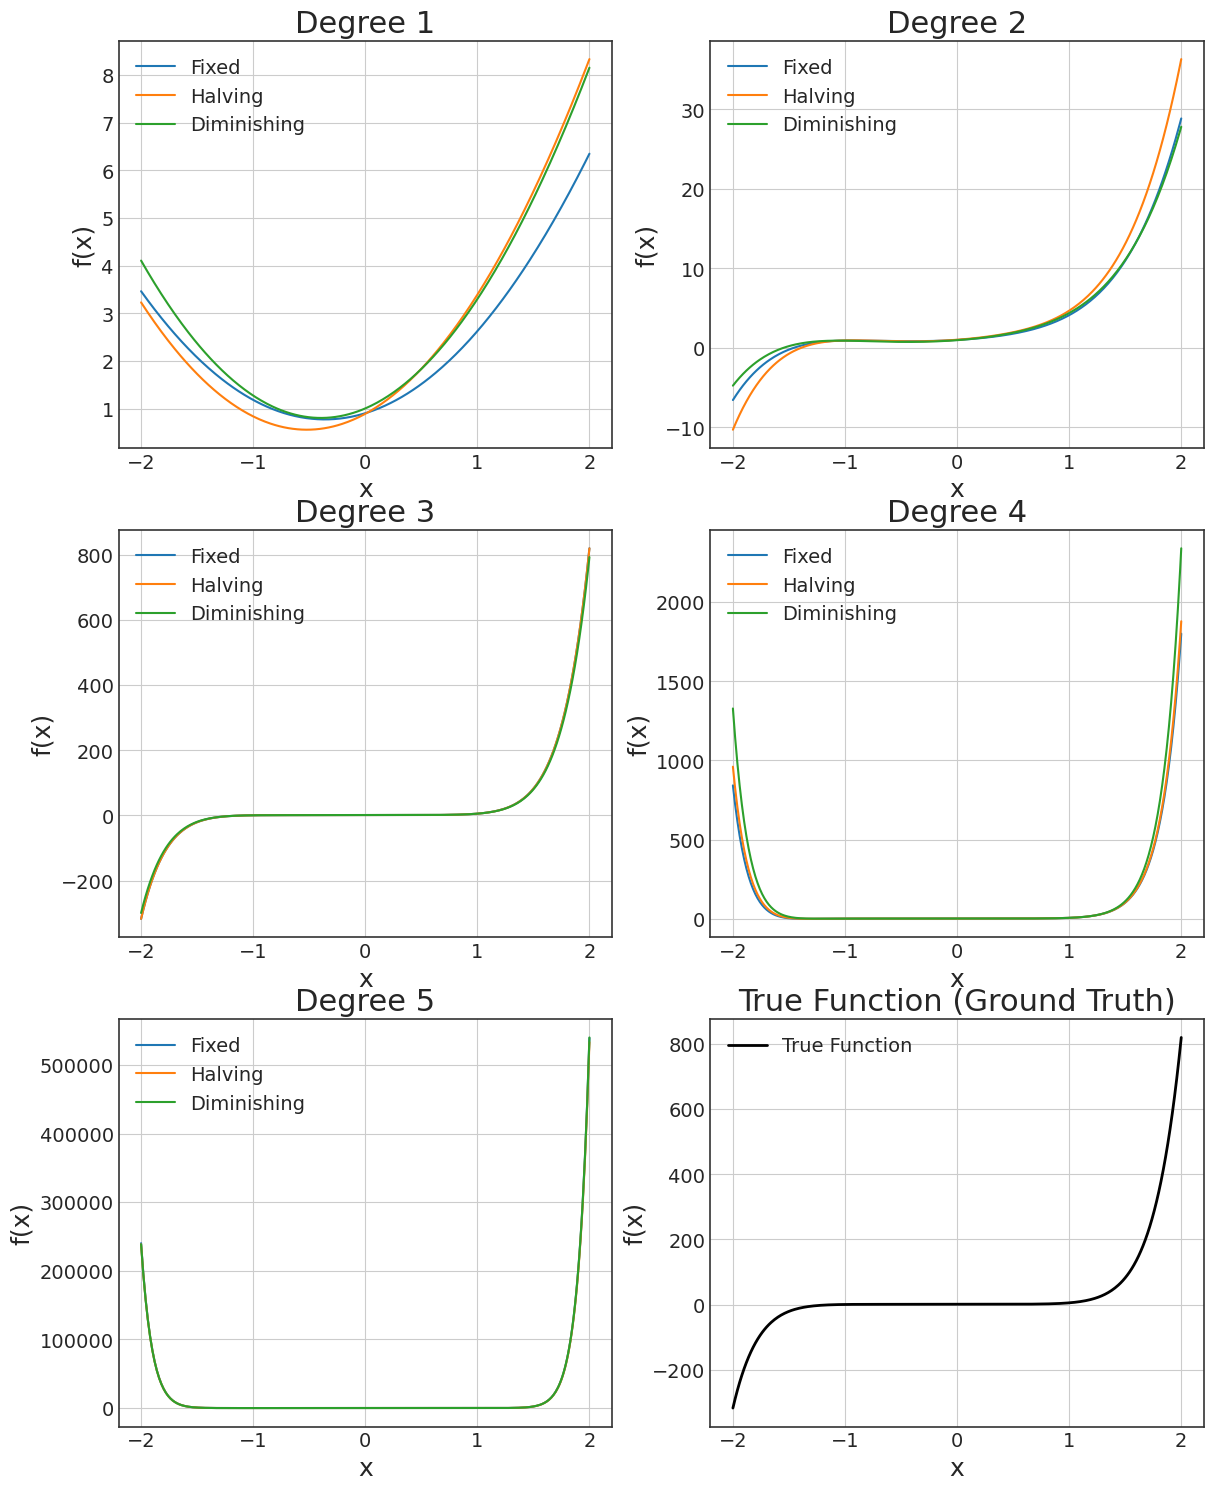

In [5]:

# x range
x = np.linspace(-2, 2, 400)

# Weights by degree and strategy
weights = {
    "Degree 1": {
        "Fixed": [0.90960545, 0.72040648, 0.99916811],
        "Halving": [0.89687516, 1.27440746, 1.2207995],
        "Diminishing": [1.01026184, 1.01032214, 1.27947988]
    },
    "Degree 2": {
        "Fixed": [1.00831545, 0.81560158, 1.18265524, 0.37022856, 0.33866186, 0.40990313],
        "Halving": [1.03479889, 1.06046181, 1.3774551, 0.19828222, 0.40505952, 0.6124351],
        "Diminishing": [0.97995532, 1.0475577, 1.35371409, 0.32730508, 0.32170957, 0.36145493]
    },
    "Degree 3": {
        "Fixed": [1.00002263, 0.10009615, 0.20012903, 0.29994096, 0.39992452, 0.49993228,
                  0.59992685, 0.70000902, 0.79998133, 0.8999619],
        "Halving": [1.00000955, 0.10030739, 0.20039768, 0.30001315, 0.39998513, 0.49991372,
                    0.59969985, 0.69987408, 0.79993912, 0.89972273],
        "Diminishing": [1.00007409, 0.14218693, 0.25115075, 0.2998401, 0.39871464, 0.49688643,
                        0.56039187, 0.67945326, 0.79197108, 0.86100887]
    },
    "Degree 4": {
        "Fixed": [1.00027469, 0.13003478, 0.23931592, 0.24075637, 0.3829104, 0.43767579,
                  0.5712494, 0.68138302, 0.80250816, 0.86851909, 0.05303119, 0.03824593,
                  0.00780721, -0.01794551, 0.06015303],
        "Halving": [1.00016336, 0.14287507, 0.25575853, 0.24808968, 0.38092021, 0.43323637,
                    0.55643718, 0.67446459, 0.79879617, 0.85773601, 0.05584382, 0.04279842,
                    0.00988293, -0.02072195, 0.06557686],
        "Diminishing": [0.99997837, 0.17208261, 0.29209032, 0.23283095, 0.36720567, 0.40782655,
                        0.52904668, 0.65709181, 0.79342278, 0.8308003, 0.07513545, 0.06144477,
                        0.00584692, -0.01762705, 0.09087633]
    },
    "Degree 5": {
        "Fixed": [0.59299797, 0.29305326, 0.38500181, 0.1066853, 0.16021707, 0.2053613,
                  0.265825, 0.3021929, 0.32356914, 0.38381826, 0.08079093, 0.07664725,
                  0.09368486, 0.09572237, 0.16247443, 0.16552196, 0.12734098, 0.17649427,
                  0.22247827, 0.22860612, 0.30518906],
        "Halving": [0.56468672, 0.27931425, 0.3692564, 0.09708337, 0.14869736, 0.1965804,
                    0.25329603, 0.28618527, 0.30827525, 0.3713634, 0.07712855, 0.07428869,
                    0.08688067, 0.08627415, 0.15696762, 0.16237398, 0.12897297, 0.17996956,
                    0.2218966, 0.22372869, 0.30157006],
        "Diminishing": [0.56059278, 0.286972, 0.37497018, 0.10408803, 0.1550874, 0.19778104,
                        0.26311819, 0.29648789, 0.31590474, 0.37574058, 0.08186102, 0.07863984,
                        0.08796461, 0.08599898, 0.15543186, 0.16883437, 0.13172977, 0.18157096,
                        0.22738718, 0.22951003, 0.30336521]
    }
}

fig, axs = plt.subplots(3, 2, figsize=(14, 18))
axs = axs.flatten()

for idx, (degree_label, strategy_dict) in enumerate(weights.items()):
    ax = axs[idx]
    ax.set_title(degree_label)
    for strategy, w in strategy_dict.items():
        y = np.zeros_like(x)
        for i, coef in enumerate(w):
            y += coef * x**i
        ax.plot(x, y, label=strategy)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.grid(True)
    ax.legend()

ax = axs[-1]
ax.set_title("True Function (Ground Truth)")
true_A = 0.1 * np.arange(1, 10)
true_b = 1.0
y_true = true_b + sum(a * x**(i + 1) for i, a in enumerate(true_A))
ax.plot(x, y_true, label='True Function', color='black', linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.grid(True)
ax.legend()


In [6]:
print("SGD Parameters for Fixed Polynomial Run (Degree = 2):")
print("="*60)
params_fixed = results[2]["fixed"]["params"]
scheduler_fixed = results[2]["fixed"]["scheduler"]
print(f"L (Lipschitz constant): {params_fixed['L']:.4f}")
print(f"c: {params_fixed['c']:.4f}")
print(f"M_G: {params_fixed['M_G']:.4f}")
print(f"M: {params_fixed['M']:.4f}")
print(f"M_V: {params_fixed['M_V']:.4f}")
print(f"mu: {params_fixed['mu']:.4f}")
print(f"mu_G: {params_fixed['mu_G']:.4f}")
print(f"Fixed stepsize (alpha): {scheduler_fixed.alpha:.6f}")
print("="*60)

print("True Parameters (used to generate synthetic data):")
print(f"A: {true_A}")
print(f"b: {true_b}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results_deg2:
    w_method = results_deg2[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...): {w_method[1:]}")


SGD Parameters for Fixed Polynomial Run (Degree = 2):
L (Lipschitz constant): 1.1268
c: 0.9465
M_G: 89.7527
M: 0.0000
M_V: 88.7527
mu: 1.0000
mu_G: 1.0000
Fixed stepsize (alpha): 0.009888
True Parameters (used to generate synthetic data):
A: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
b: 1.0

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------


NameError: name 'results_deg2' is not defined